In [2]:
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [3]:
LAG_ORDER = 2
HORIZON = 20

In [55]:
SIGNIFICANT_P = 0.05
def test_stationarity(data, maxlag):
    # AIC - autolag parameter which automates
    # the selection of the lag length based on information criteria and penalises complex models.

    # ct - ct: It stands for "constant and trend."
    # The regression model includes both a constant (intercept) and a linear trend term.
    result = adfuller(data, maxlag=maxlag, regression='ct')
    isStationary = False
    if (result[0] < result[4]["1%"] and result[0] < result[4]["5%"] and result[0] < result[4]["10%"]\
        and result[1] < SIGNIFICANT_P):
        isStationary = True
    else:
        isStationary = False
    
    return { "stationarity": result, "isStationary": isStationary }

In [5]:
def forecast_accuracy(forecast, actual):
        print(forecast)
        print("------------")
        print(actual)
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
        me = np.mean(forecast - actual)             # ME
        mae = np.mean(np.abs(forecast - actual))    # MAE
        mpe = np.mean((forecast - actual)/actual)   # MPE
        rmse = np.mean((forecast - actual)**2)**.5  # RMSE
        # corr = np.corrcoef(forecast, actual)[0,1]   # corr
        # mins = np.amin(np.hstack([forecast[:,None], 
        #                         actual[:,None]]), axis=1)
        # maxs = np.amax(np.hstack([forecast[:,None], 
        #                         actual[:,None]]), axis=1)
        # minmax = 1 - np.mean(mins/maxs)             # minmax
        return({'mape':mape, 'me':me, 'mae': mae, 
                'mpe': mpe, 'rmse':rmse })


In [59]:
def convert_data_to_stationary(df, maxlag):
    # how to deal with non linear non stationarity?
    # put an upper limit on the order
    df_diff = df.copy()
    diff_order = -1
    is_stationary = False
    while is_stationary == False:
        diff_order += 1
        for i in range(len(df_diff.columns)):

            stationarityTestResult = test_stationarity(df_diff[df_diff.columns[i]], maxlag)
            is_stationary = stationarityTestResult["isStationary"]
            print('Column {0} stationarity: {1}'.format(df_diff.columns[i], is_stationary))
            if is_stationary == False:
                print('False')
                break
        print("is_stationary -> {0}, differenced {1} times".format(is_stationary, diff_order))
        # Apply differencing to make data stationary
        df_diff = df_diff.diff().dropna()
    return df_diff, diff_order

In [68]:
class Predict:
    def __init__(self):
        self = self


    def df_test_transformation(self, df, scaler):
        print("sound (original)")
        plt.hist(df["sound"])
        plt.show()
        
        df_diff, diff_order = convert_data_to_stationary(df)  


        # Scale data using the previously defined scaler
        df_scaled = pd.DataFrame(scaler.fit_transform(df_diff), 
                            columns=df_diff.columns, 
                            index=df_diff.index)
        
        
        print("sound (differenced)")
        plt.hist(df_diff["sound"], bins=np.linspace(-5, 5, 100))
        plt.show()

        print("sound (scaled)")
        plt.hist(df_scaled["sound"], bins=np.linspace(-10, 10, 100))
        plt.show()

        return df_scaled, diff_order
    
    def df_inv_transformation(self, pred, df_original, scaler):
        forecast = pred.copy()
        df_diff = pd.DataFrame(scaler.inverse_transform(forecast), 
                        columns=forecast.columns, 
                        index=forecast.index)
        columns = df_original.columns
        for col in columns:
            df_diff[str(col)] = df_original[col][df_original.index < pred.index[0]].iloc[-1] + \
                df_diff[str(col)+"_pred"].cumsum()
        return df_diff
    
    def test_var(self, df_input):
        df_input.index = pd.to_datetime(df_input.index, unit = 'ms')
        # Is this ts unique? (check with pandas)
        scaler = StandardScaler()

        # # Apply function to our data
        df_scaled, diff_order = self.df_test_transformation(df_input, scaler)
        cutoff_index = int(df_scaled.shape[0] * 0.9)
        df_train = df_scaled.iloc[:cutoff_index]
        df_test = df_scaled.iloc[cutoff_index:]

        model = VAR(df_train)
        # Get optimal lag order based on the four criteria
        optimal_lags = model.select_order()

        print(f"The optimal lag order selected: {optimal_lags.selected_orders}")
        # Fit the model after selecting the lag order
        lag_order = LAG_ORDER # optimal_lags.selected_orders['aic']
        results = model.fit(lag_order)
        print(results)
        print(results.params)
        # print(results.rsquared)
        print(str(results.summary()))
        # Estimate the model (VAR) and show summary
        # Forecast next two weeks
        horizon = HORIZON
        def run_forecast(df_to_run_forecast_on, df_original):
            forecast = results.forecast(df_to_run_forecast_on.values[-lag_order:], steps=horizon)

            idx = pd.date_range(pd.to_datetime(df_to_run_forecast_on.iloc[-1:].index.item(), unit='ms'), periods=horizon, freq='120s')
            # Convert to dataframe
            df_forecast = pd.DataFrame(forecast, 
                            columns=df_to_run_forecast_on.columns + '_pred', 
                            index=idx)
            
            # # Invert the transformations to bring it back to the original scale
            # df_forecast_original = self.df_inv_transformation(df_forecast, df_original, scaler)

            return df_forecast
        
        df_forecast_on_train_data = run_forecast(df_train, df_input)
        # Invert the transformations to bring it back to the original scale
        df_forecast_on_train_data_original = self.df_inv_transformation(df_forecast_on_train_data, df_input, scaler)

        df_forecast_test_data = run_forecast(df_test, df_input)
        df_forecast_on_test_data_original = self.df_inv_transformation(df_forecast_test_data, df_input, scaler)
    
        df_forecast_future_data = run_forecast(df_scaled, df_input)
        print(df_forecast_test_data)
        predicted_values = df_forecast_test_data["sound_pred"]
        actual_values_df = df_scaled[df_scaled.index.isin(predicted_values.index)] 
        actual_values = actual_values_df["sound"]

        evaluation_result = forecast_accuracy(predicted_values, actual_values)

        print("Evaluate test data: ")
        print(evaluation_result)
        # print(evaluation_result)
        
        # json_result = df_forecast_on_test_data_original.to_json()
        # with open('data.json', 'w', encoding='utf-8') as f:
        #     json.dump(json_result, f, ensure_ascii=False, indent=4)
        # return json_result

In [11]:
f = open('/Users/yarynakorduba/Projects/master-thesis-full-stack/src/front/js/pages/App/test.json')
data_serie = json.load(f)
data_serie[1]

{'oxygen': 20.636,
 'timestamp': 1690675362000,
 'health': 809,
 'dewpt': 15.702,
 'no2': 48.89,
 'TypPS': 1.7,
 'tvoc': 383,
 'gauss': 0.8380579546869671,
 'sound': 32.06,
 'temperature': 23.611,
 'co2': 413}

In [12]:
data_serie_trimmed = data_serie
data_df = pd.DataFrame.from_records(data_serie_trimmed)
data_df = data_df.filter(['sound','co2'], axis=1)

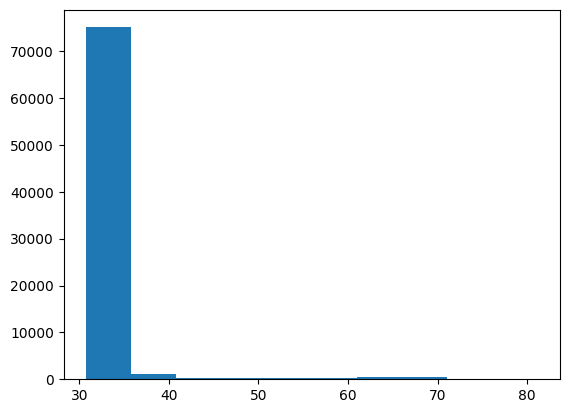

In [34]:
plt.hist(data_df["sound"])
plt.show()

In [45]:
data_df.isna().sum() # -> no missing values imputation needed

sound    0
co2      0
dtype: int64

In [14]:
print(data_df.min())
print(data_df.max())


sound     30.77
co2      405.10
dtype: float64
sound      81.09
co2      1666.80
dtype: float64


In [63]:
df_diff, diff_order = convert_data_to_stationary(data_df)  

Column sound stationarity: True
Column co2 stationarity: True
is_stationary -> True, differenced 0 times


sound (original)


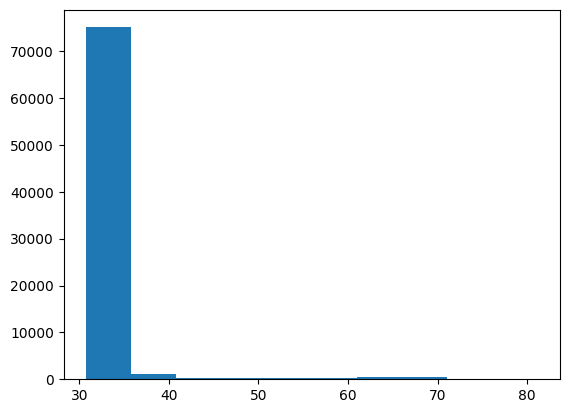

Column sound stationarity: True
Column co2 stationarity: True
is_stationary -> True, differenced 0 times
sound (differenced)


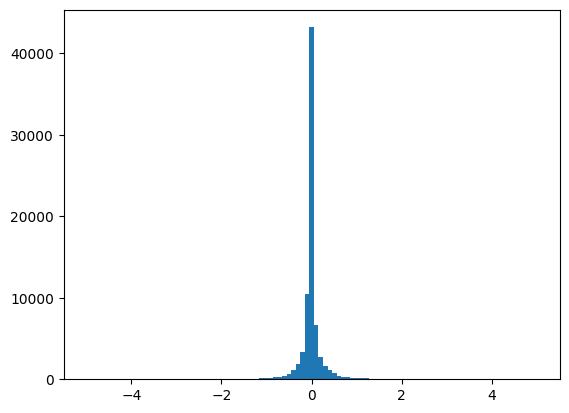

sound (scaled)


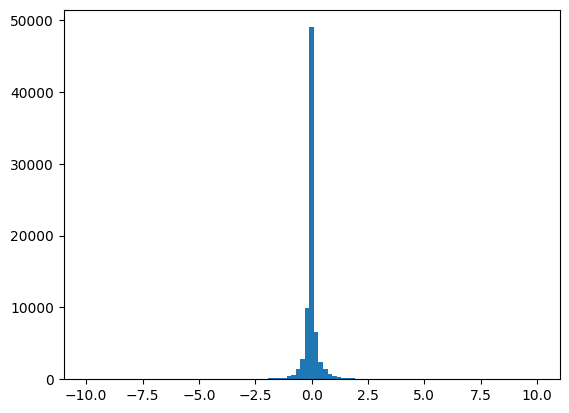

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


The optimal lag order selected: {'aic': 62, 'bic': 62, 'hqic': 62, 'fpe': 62}
              sound       co2
const     -0.000032  0.000246
L1.sound  -0.148059  0.061686
L1.co2    -0.035996 -0.091187
L2.sound  -0.116644  0.053934
L2.co2    -0.019480 -0.035737
...             ...       ...
L60.co2    0.029932 -0.029622
L61.sound -0.009726  0.025012
L61.co2    0.014269  0.046349
L62.sound -0.003486  0.017972
L62.co2    0.012509 -0.015083

[125 rows x 2 columns]
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Feb, 2024
Time:                     13:23:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0802476
Nobs:                     70498.0    HQIC:                 -0.102724
Log likelihood:          -195841.    FPE:                   0.893381
AIC:                    -0.112743    Det(Omega_mle):        0.890221
------------------

In [71]:
result = Predict().test_var(data_df)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [43]:
lagged_data_order = 2  # You can adjust the number of lags based on the characteristics of your data
key = 'sin_data'
steps = 20
# Generate sinusoidal data
np.random.seed(42)
t = np.linspace(0, 4*np.pi, 1000)
sin_data = np.sin(t) # + np.random.normal(scale=0.1, size=len(t))

# Create a DataFrame
data = pd.DataFrame(sin_data, columns=[key])


# Lag the data to create a VAR model
for i in range(1, lagged_data_order):
    data[f'{key}_lag{i}'] = (data[key] * 10).shift(i)

# Drop NaN values created by lagging
data = data.dropna()


In [47]:
lagged_data_order = 2  # You can adjust the number of lags based on the characteristics of your data
steps = 100
key = 'sound'
data = data_df.copy()

data = data.dropna()
data[key] = data[key].astype(float)
np.asarray(data)
data

,sound,co2
0,32.08,413.0
1,32.06,413.0
2,32.07,411.9
3,32.10,411.7
4,32.07,411.6
...,...,...
78396,33.29,459.2
78397,33.35,459.0
78398,33.37,458.8
78399,33.34,458.7


Column sound stationarity: True
Column co2 stationarity: True
is_stationary -> True, differenced 0 times
Train size 70560
mape_val scaled: 1.5334716331129667
mape_val: 0.014994090060572243


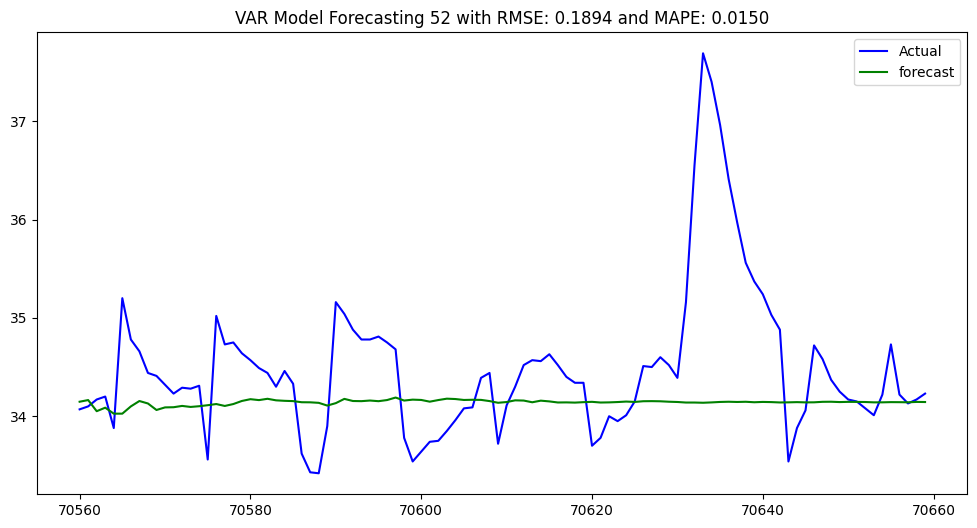

mape_val scaled: 1.605934297345366
mape_val: 0.01513579942219675


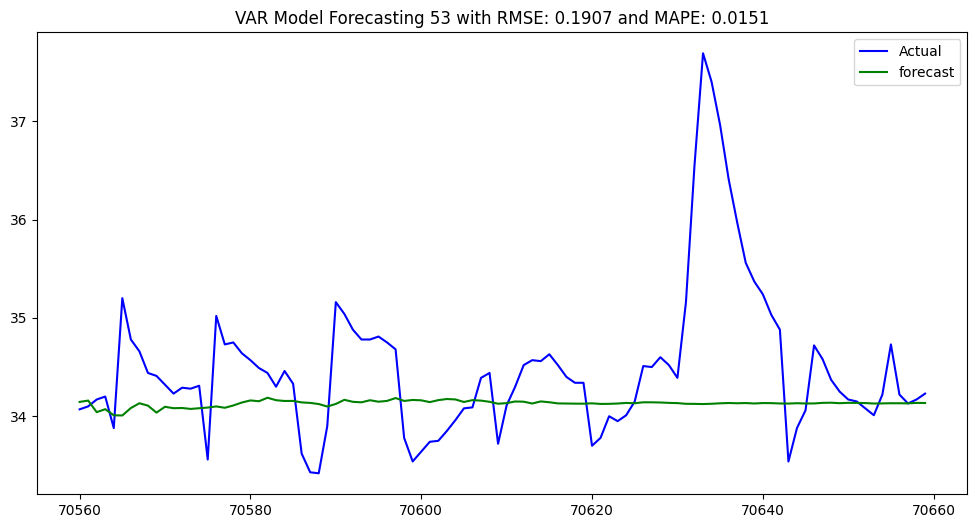

mape_val scaled: 1.6003946783363197
mape_val: 0.015116760783072032


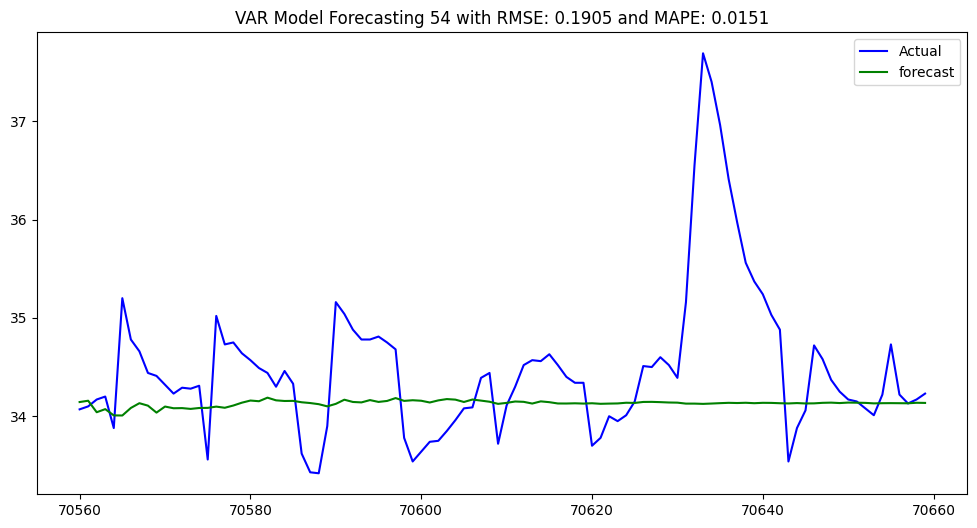

mape_val scaled: 1.5418479574937831
mape_val: 0.014992269308259372


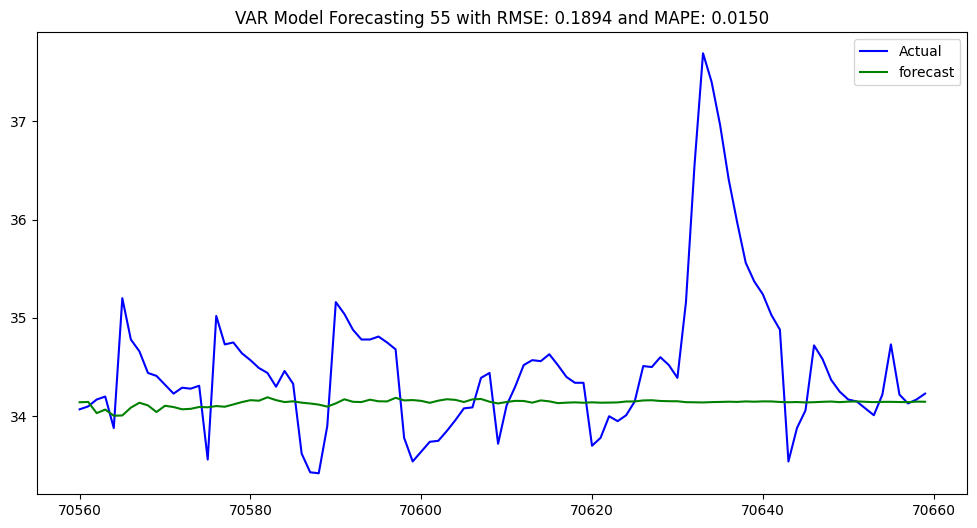

mape_val scaled: 1.6807373935565963
mape_val: 0.01526135909706635


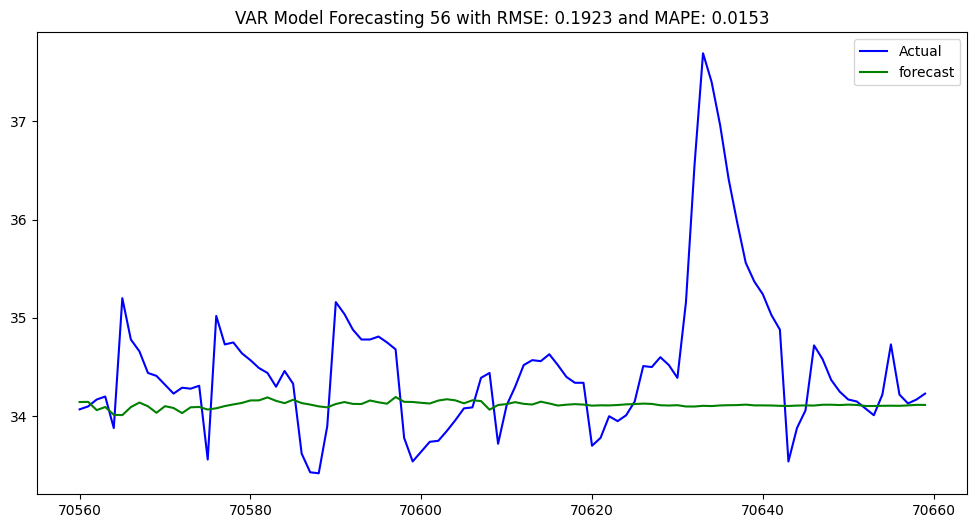

mape_val scaled: 1.7395212246558471
mape_val: 0.015370503102250138


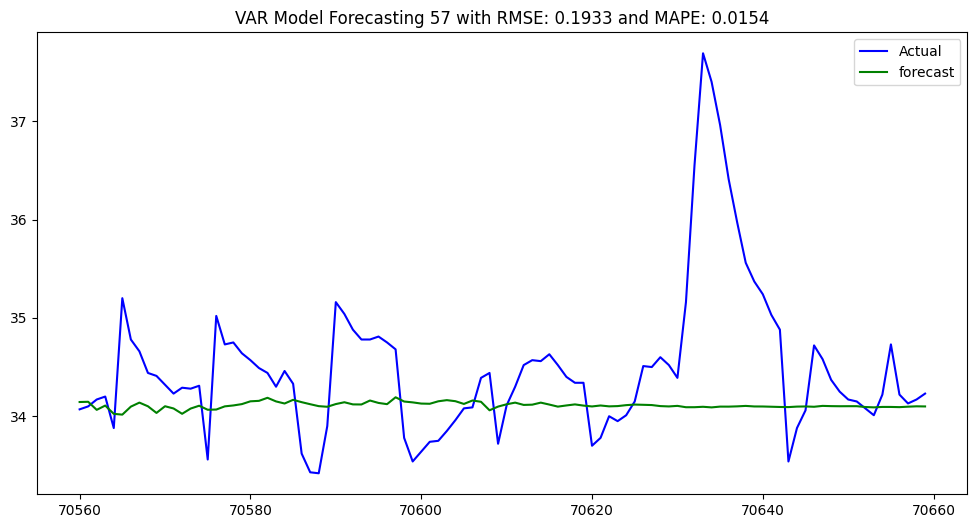

mape_val scaled: 1.7019306582297373
mape_val: 0.015326432279867677


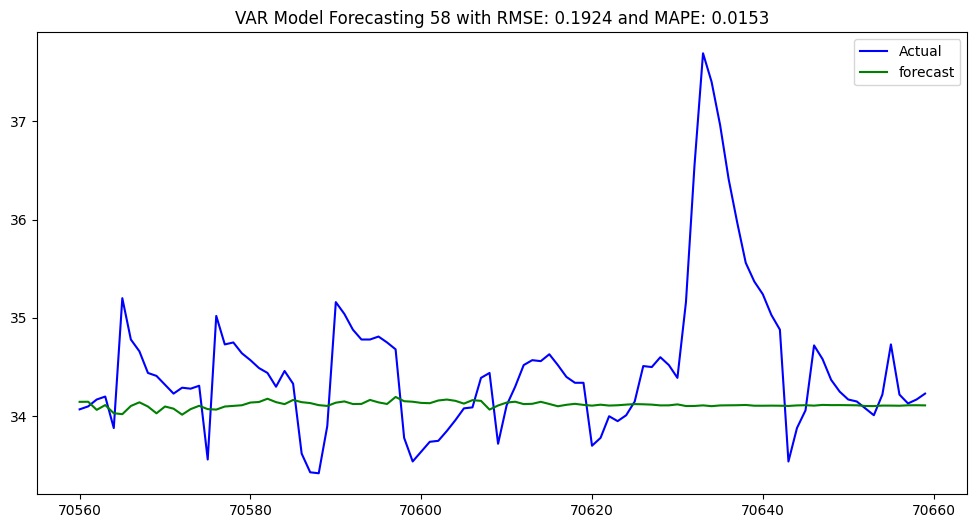

mape_val scaled: 1.75873964162233
mape_val: 0.015387724782331797


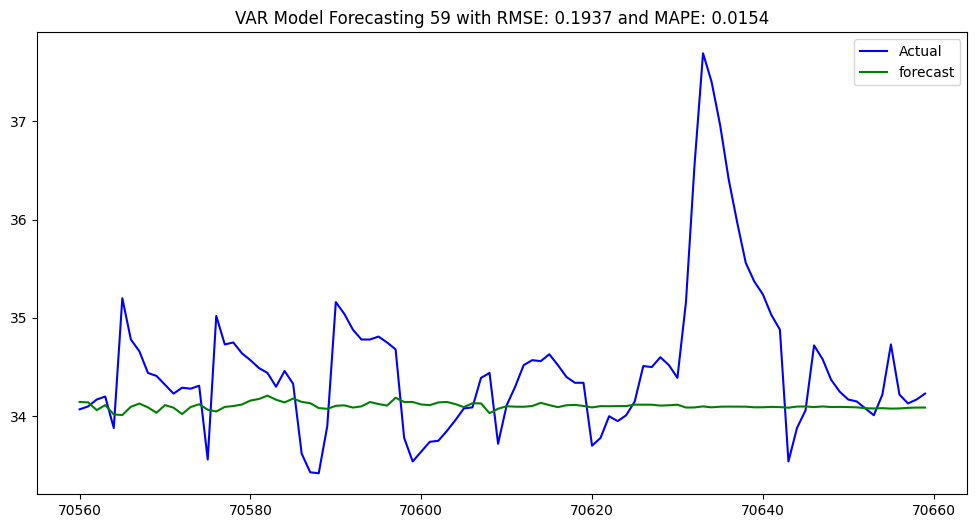

mape_val scaled: 1.8408394361260896
mape_val: 0.015534280432019274


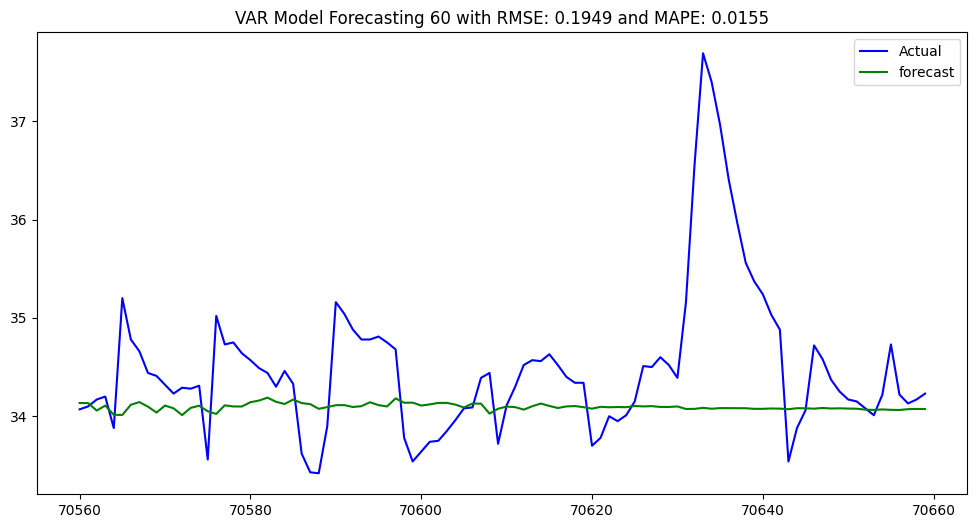

mape_val scaled: 1.8728920757882037
mape_val: 0.015602474366214465


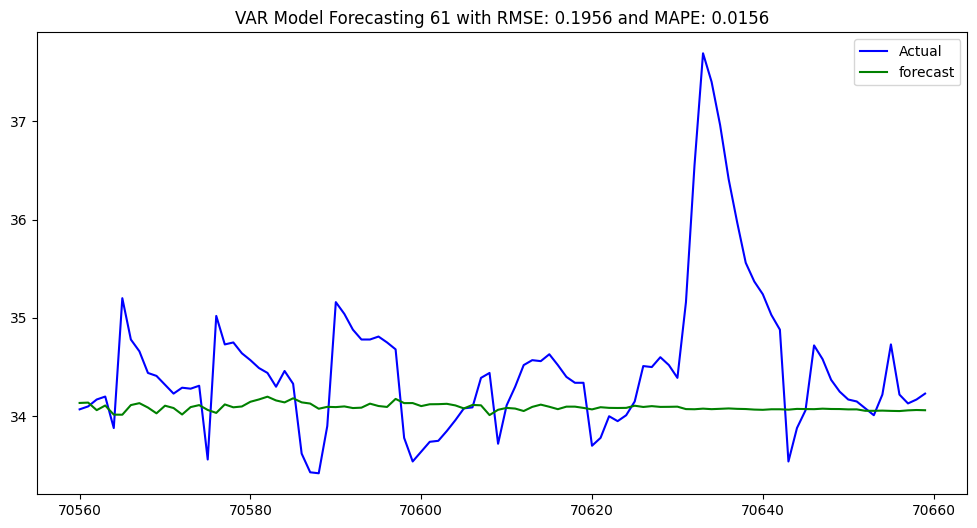

mape_val scaled: 1.9010485666113894
mape_val: 0.01566950218645548


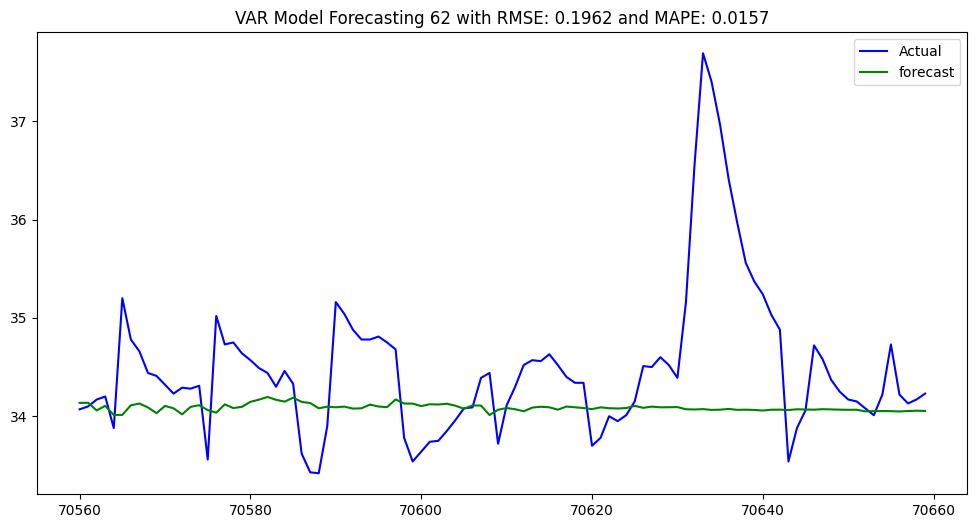

Best case: lag order 55 with MAPE 0.014992269308259372


In [60]:
max_lag_order = 62
stationarityTestResult = convert_data_to_stationary(data, max_lag_order)

# Initiate standard scaler to scale data in different columns
scaler = StandardScaler()

# Scale data using the previously defined scaler
data_scaled = pd.DataFrame(scaler.fit_transform(data), 
                    columns=data.columns, 
                    index=data.index)

train_size = int(0.9 * len(data_scaled))
print("Train size {0}".format(train_size))
train, test = data_scaled.iloc[:train_size], data_scaled.iloc[train_size:]
real_data_counterpart = data.iloc[train_size:].head(steps)
real_data_counterpart_scaled = test.head(steps)

results = {}
for l in range(52, max_lag_order+1):


    # Fit VAR model
    model = VAR(train)
    model_fitted = model.fit(l)

    # Forecasting
    lag_order = model_fitted.k_ar
    forecast_scaled_data = model_fitted.forecast(train.values[-lag_order:], steps=steps)
    forecast_scaled = pd.DataFrame(forecast_scaled_data, columns=data_scaled.columns, index=real_data_counterpart_scaled.index)
    
    # Inverting the scaling

    forecast = pd.DataFrame(scaler.inverse_transform(forecast_scaled, copy=True), 
                columns=forecast_scaled.columns, 
                index=forecast_scaled.index)

    # Calculate RMSE
    rmse_val = np.sqrt(mean_squared_error(forecast_scaled[key], real_data_counterpart_scaled[key]))
    mape_val = (mean_absolute_percentage_error(real_data_counterpart[key], forecast[key], multioutput='uniform_average'))  # MAPE
    mape_val_scaled = (mean_absolute_percentage_error(real_data_counterpart_scaled[key], forecast_scaled[key], multioutput='uniform_average'))  # MAPE
    print(f'mape_val scaled: {mape_val_scaled}')
    print(f'mape_val: {mape_val}')


    # Evaluating and plotting
    results[lag_order] = mape_val
    # Plot the results
    # plt.figure(figsize=(12, 6))
    # plt.plot(real_data_counterpart_scaled.index, real_data_counterpart_scaled[key], label='Actual', color='blue')
    # plt.plot(forecast_scaled.index, forecast_scaled[key], label='forecast', color='green')
    # plt.title(f'VAR Model Forecasting {lag_order} with RMSE: {rmse_val:.4f} and MAPE: {mape_val:.4f}')
    # plt.legend() 
    # plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(real_data_counterpart.index, real_data_counterpart[key], label='Actual', color='blue')
    plt.plot(forecast.index, forecast[key], label='forecast', color='green')
    plt.title(f'VAR Model Forecasting {lag_order} with RMSE: {rmse_val:.4f} and MAPE: {mape_val:.4f}')
    plt.legend() 
    plt.show()

min_key = min(results, key=results.get)
print("Best case: lag order {0} with MAPE {1}".format(min_key, results[min_key]))